In [ ]:
# General imports
import os
import PIL
import time
import glob
import imageio
import numpy as np
import pandas as pd
from IPython import display
import matplotlib.pyplot as plt

# Tensorflow imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.datasets.mnist import load_data

In [ ]:
# Load MNIST dataset
(train_images, train_labels), (test_images, test_labels) = load_data()

In [ ]:
train_images.shape

(60000, 28, 28)

In [ ]:
train_labels.shape

(60000,)

In [ ]:
test_images.shape

(10000, 28, 28)

In [ ]:
test_labels.shape

(10000,)

In [ ]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

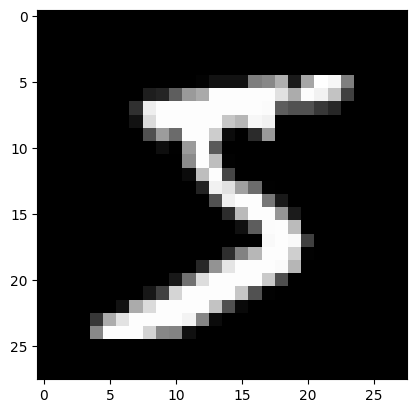

In [ ]:
plt.imshow(train_images[0], cmap="gray")

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [ ]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
generator = keras.Sequential([
    # Start with a dense layer and reshape into a 7x7 feature map with 256 channels.
    layers.Dense(7 * 7 * 256, input_dim=200),
    layers.Reshape((7, 7, 256)),
    layers.BatchNormalization(),
    layers.ReLU(),

    # Upsample to 14x14 using a transposed convolution.
    layers.Conv2DTranspose(128, kernel_size=5, strides=1, padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),

    layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),

    # Upsample to 28x28. Output a single channel with tanh activation.
    layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding='same', activation='tanh')
])


In [ ]:
discriminator = tf.keras.Sequential([
    # Input layer takes MNIST images (28x28x1)
    layers.Conv2D(64, kernel_size=5, strides=2, padding='same', input_shape=(28, 28, 1)),
    layers.LeakyReLU(alpha=0.2),
    layers.Dropout(0.3),

    layers.Conv2D(128, kernel_size=5, strides=2, padding='same'),
    layers.LeakyReLU(alpha=0.2),
    layers.Dropout(0.3),

    layers.Flatten(),
    layers.Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])


In [ ]:
# Base loss function for DCGAN
bce_loss = keras.losses.BinaryCrossentropy()

In [ ]:
def compute_discriminator_loss(disc_pred_for_real_img, disc_pred_for_fake_img):
  # Calculate loss between discriminator's prediction for real image and ground truth (1)
  real_loss = bce_loss(
      tf.ones_like(disc_pred_for_real_img),
      disc_pred_for_real_img,
  )

  # Calculate loss between discriminator's prediction for generated image and ground truth (0)
  fake_loss = bce_loss(
      tf.zeros_like(disc_pred_for_fake_img),
      disc_pred_for_fake_img,
  )

  return real_loss + fake_loss

In [ ]:
def compute_generator_loss(gen_output_for_fake_img):
  # Calculate loss between generator's output for generated image and ground truth (1)
  gen_loss = bce_loss(
      tf.ones_like(gen_output_for_fake_img),
      gen_output_for_fake_img,
  )
  return gen_loss


In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
EPOCHS = 100
noise_dim = 200
num_examples_to_generate = 8

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = compute_generator_loss(fake_output)
      disc_loss = compute_discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  # display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

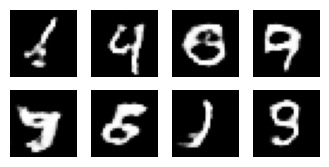

Time for epoch 100 is 12.591822862625122 sec


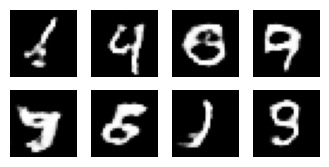

In [ ]:
train(train_dataset, EPOCHS)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

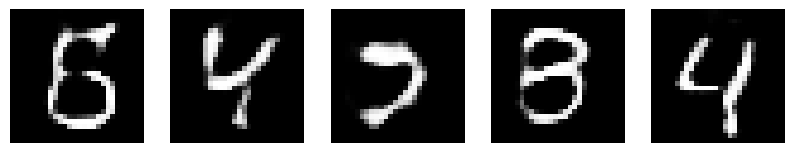

In [ ]:
#Generate Random Numbers from the trained model

noise_dim = 200

# Generate random noise
num_images = 5 # Number of images to generate
random_noise = tf.random.normal([num_images, noise_dim])

# Generate images using the trained generator
generated_images = generator(random_noise, training=False)

# Plot the generated images
fig, axes = plt.subplots(1, num_images, figsize=(10, 10))
for i in range(num_images):
    axes[i].imshow(generated_images[i, :, :, 0], cmap='gray')  # Assuming single-channel grayscale images
    axes[i].axis('off')

plt.show()